In [1]:
#delete later
#_ih[-20:]

# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

# define path
my_path = "/Users/meikeepauline/Desktop/IP/CaseStudy/"

# columns (not) to be analysed
except_column   = ["ID", "deflag"]
analysis_columns = ["var1_AQ","var2_AQ","var3_CL","var4_CL","var5_LF","var6_LF","var7_PE","var8_PE","var9_LF","var10_PE",
"var11_AQ","var12_PE","var13_PE","var14_LF","var15_PE","var16_AQ","var17_LF","var18_CL","var19_AQ","var20_AQ","var21_LF",
"var22_AQ","var23_PE","var24_LF","var25_LF","var26_LF"]

# parameter
test_sample_size = 0.3
seed = 31032023

# set pd options to see all info of dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# remove specific  warnings
pd.options.mode.chained_assignment = None
plt.rcParams.update({'figure.max_open_warning': 0})

# Turn interactive plotting off
plt.ioff()

KeyboardInterrupt: 

In [16]:
# import data
data = pd.read_excel(my_path + "DataPD.xlsx")

In [17]:
# create statistics for whole data set
print(data.head())          # print first 5 rows
print(data.info())          # print information of data (null, type)
print(data.describe())      # print statistics

# export result
data.describe().to_excel(my_path + "/Export/" + "Descriptive_statistics_before.xlsx")  

   ID  deflag   var1_AQ   var2_AQ    var3_CL   var4_CL   var5_LF   var6_LF  \
0   1       0  0.451877       NaN  22.369781  0.084089       NaN  0.398630   
1   2       0  5.516033 -0.110378  12.772155  0.139006  1.081491  0.023785   
2   3       0  0.781693 -0.023390        NaN  0.186470  0.543743  0.349677   
3   4       0  3.241453  0.372442        NaN  0.123212  0.781212  0.180893   
4   5       0  1.757127       NaN  14.341708  0.010445  0.703393  0.605375   

    var7_PE   var8_PE   var9_LF  var10_PE  var11_AQ  var12_PE  var13_PE  \
0  1.011158       NaN -0.013473 -0.000590  1.150207       NaN  0.050189   
1  1.041538  0.251213  0.030126  0.025606  1.099361       NaN  0.064654   
2  1.041045  0.000742  0.022277  0.006097  0.922969  0.546460       NaN   
3  1.001151  0.059936  0.056857  0.007628  1.080822  0.669822       NaN   
4  1.017952  0.137188  0.010855 -0.000510  1.082658  0.765356  0.042959   

   var14_LF  var15_PE   var16_AQ  var17_LF   var18_CL  var19_AQ  var20_AQ  \
0  

In [ ]:
#create distribution plot and boxplot
for col in data.columns[2:]:
    fig1 = plt.figure()
    sns.displot(data[col])
    plt.savefig(my_path + "/Plot/" + col + '_Distr.png')
    plt.close(fig1)

    fig2 = plt.figure()
    plt.title(col)
    sns.boxplot(data=data[col])
    plt.savefig(my_path + "/Plot/" + col + '_Boxplot.png')
    plt.close(fig2)

plt.close('all')

In [21]:
# Calculate Quantiles, Interquantile, Lower and Upper Limit, save in Dataframe perc
def quantiles(var):

    IQ = np.subtract(*np.nanpercentile(var, [75, 25]))
    Q25 = np.nanpercentile(var, 25)
    Q75 = np.nanpercentile(var, 75)
    UL = Q75+1.5*IQ
    LL = Q25-1.5*IQ

    return IQ, Q25, Q75, UL, LL

perc = data[analysis_columns].apply(quantiles)
Description = ['Interquantile', '25thQuantile', '75thQuantile', 'Upper Limit', 'Lower Limit']
perc.insert(0, 'Description', Description)

# export result
perc.to_excel(my_path + "/Export/" + "IQR.xlsx")  

# Set values above UL and below LL to NaN, save in Dataframe data_nO
data_nO = data[except_column]

for col in data.columns[2:]:
    #data_nO[col] = np.where(data[col] == 99, np.NaN, np.where(data[col] > perc.iloc[3][col], np.NaN, np.where(data[col] < perc.iloc[4][col], np.NaN, data[col])))
    data_nO[col] = np.where(data[col] > perc.iloc[3][col], np.NaN, np.where(data[col] < perc.iloc[4][col], np.NaN, data[col]))
    #data_nO[col] = np.where(data[col] > perc.iloc[3][col], perc.iloc[3][col], np.where(data[col] < perc.iloc[4][col], perc.iloc[4][col], data[col]))

data_nO["Num_of_Miss"] = data_nO.isnull().sum(axis=1)

In [28]:
# Caclulate Average, Median, etc. and save in Dataframe stats
stats = data_nO[analysis_columns].describe().reset_index()
print(stats)

# export result
stats.to_excel(my_path + "/Export/" + "Descriptive_statistics_after.xlsx")  

# Number of missing values to be replaced
print("Missing values: \n", data_nO.isna().sum())

# Final adaptions, save in Dataframe data_fin
data_fin = data[except_column]

for col in data.columns[2:]:
    # outlier treatment
    data_fin[col] = np.where(data[col] > perc.iloc[3][col], perc.iloc[3][col], np.where(data[col] < perc.iloc[4][col], perc.iloc[4][col], data[col]))
    
    # missing values treatment
    data_fin[col] = data_fin[col].fillna(stats.iloc[5][col])

    # standardization
    data_fin[col] = (data_fin[col] - stats.iloc[1][col])/stats.iloc[2][col]

data_fin["Num_of_Miss"] = data_nO["Num_of_Miss"]

   index       var1_AQ       var2_AQ       var3_CL       var4_CL  \
0  count  28095.000000  26346.000000  25557.000000  28006.000000   
1   mean      1.783829      0.229338     16.122738      0.076315   
2    std      1.805723      0.233960      7.497544      0.042671   
3    min     -1.519354     -0.210979      0.574025     -0.007078   
4    25%      0.447475      0.057569     10.635332      0.044836   
5    50%      1.530670      0.197086     15.405572      0.071625   
6    75%      2.872955      0.368761     20.939003      0.103199   
7    max      7.157460      0.914267     37.827036      0.202066   

        var5_LF       var6_LF       var7_PE       var8_PE       var9_LF  \
0  25371.000000  26034.000000  27111.000000  25731.000000  27084.000000   
1      0.847603      0.224093      1.012537      0.068687      0.024077   
2      0.307146      0.180209      0.018683      0.061559      0.019800   
3      0.200855     -0.115131      0.966805     -0.070555     -0.014995   
4      0.623

In [29]:
#create distribution plot after outlier and missing data treatment
for col in data_fin.columns[2:]:
    fig = plt.figure()
    sns.displot(data_fin[col])
    plt.savefig(my_path + "/Plot/" + col + '_Distr_after.png')
    plt.close(fig)

plt.close('all')

In [30]:
# create correlation matrix
correlation = data_fin.corr()
print(correlation)

# export result
correlation.to_excel(my_path + "/Export/" + "Correlation.xlsx")  

                   ID    deflag   var1_AQ   var2_AQ   var3_CL   var4_CL  \
ID           1.000000 -0.007008 -0.004462  0.008216 -0.002318  0.001469   
deflag      -0.007008  1.000000  0.050791  0.067809 -0.046059 -0.018163   
var1_AQ     -0.004462  0.050791  1.000000 -0.265079  0.036548  0.100150   
var2_AQ      0.008216  0.067809 -0.265079  1.000000 -0.157154 -0.186042   
var3_CL     -0.002318 -0.046059  0.036548 -0.157154  1.000000  0.384516   
var4_CL      0.001469 -0.018163  0.100150 -0.186042  0.384516  1.000000   
var5_LF     -0.014005  0.133863  0.018059  0.032194 -0.149642 -0.011602   
var6_LF      0.003856 -0.055645 -0.114666  0.125610  0.058505 -0.013588   
var7_PE     -0.007167 -0.066674  0.188350 -0.146900  0.083585  0.090845   
var8_PE     -0.004342 -0.024697  0.208205 -0.129009 -0.081681  0.048830   
var9_LF     -0.003964  0.056306  0.122350 -0.090830 -0.061525 -0.066396   
var10_PE    -0.007731 -0.027738  0.211644 -0.172134  0.058788  0.213995   
var11_AQ    -0.002168  0.

In [31]:
# splitting data into test and train
train, test = train_test_split(data_fin, test_size=test_sample_size, random_state=seed, stratify=data_fin['deflag'])

print(train['deflag'].value_counts())
print("\n")
print(test['deflag'].value_counts())

0    20633
1      367
Name: deflag, dtype: int64


0    8843
1     157
Name: deflag, dtype: int64


In [32]:
from scipy import stats

# Calculate AUC, GINI and plot ROC-curve

def plot_roc_curve(y, y_pred, gini, ks):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, 'b--', label='%s AUC = %0.4f, GINI = %0.2f, KS = %s' % ('Model: ', roc_auc, gini, ks))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.savefig(my_path + "/Plot/" + col + '_ROC.png')
    plt.close(fig)

gini_ks = pd.DataFrame(columns=['Variable', 'AUC', 'GINI', 'KS'])

for col in train.columns[2:]:
    AUC = roc_auc_score(train['deflag'], train[col])
    gini = 2 * AUC - 1
    ks = stats.ks_2samp(train[train['deflag'] == 0][col], train[train['deflag'] == 1][col]).statistic

    temp = pd.DataFrame([[col, AUC, gini, ks]],columns=['Variable','AUC', 'GINI', 'KS'])
    gini_ks = pd.concat([gini_ks, temp])

    plot_roc_curve(train['deflag'], train['var1_AQ'], gini, ks)

plt.close('all')

gini_ks.to_excel(my_path+ "/Export/" + "Gini.xlsx")  

print(gini_ks)

      Variable       AUC      GINI        KS
0      var1_AQ  0.573176  0.146352  0.218614
0      var2_AQ  0.597780  0.195560  0.269946
0      var3_CL  0.360534 -0.278931  0.260520
0      var4_CL  0.438371 -0.123258  0.183702
0      var5_LF  0.764729  0.529459  0.392098
0      var6_LF  0.366462 -0.267076  0.236202
0      var7_PE  0.341948 -0.316105  0.254130
0      var8_PE  0.440582 -0.118836  0.115950
0      var9_LF  0.612358  0.224716  0.177655
0     var10_PE  0.441784 -0.116432  0.103645
0     var11_AQ  0.541737  0.083474  0.074280
0     var12_PE  0.509047  0.018094  0.035292
0     var13_PE  0.593356  0.186712  0.148838
0     var14_LF  0.741744  0.483487  0.366542
0     var15_PE  0.418354 -0.163293  0.135609
0     var16_AQ  0.631374  0.262749  0.223236
0     var17_LF  0.500335  0.000671  0.034146
0     var18_CL  0.357547 -0.284905  0.295184
0     var19_AQ  0.567080  0.134160  0.110558
0     var20_AQ  0.572656  0.145313  0.157002
0     var21_LF  0.418304 -0.163393  0.142278
0     var2

In [33]:
# Correlation of variables with GINI values above selected threshold
corr_var = data_fin[["var3_CL","var5_LF","var6_LF","var7_PE","var9_LF","var14_LF","var16_AQ","var18_CL","var24_LF","var26_LF","Num_of_Miss"]].corr()

corr_var.to_excel(my_path + "/Export/" + "Correlation_selectVAR.xlsx")  

Accuracy of logistic regression classifier on test set: 0.98
R-square: 
 train:  0.9823809523809524 
 test:  0.9825555555555555
R-square adjusted: 
 train:  0.9823742374849992 
 test:  0.9825400338610215
[[8841    2]
 [ 155    2]]
GINI: 
 train:  0.01055992021458163 
 test:  0.012512685913000476


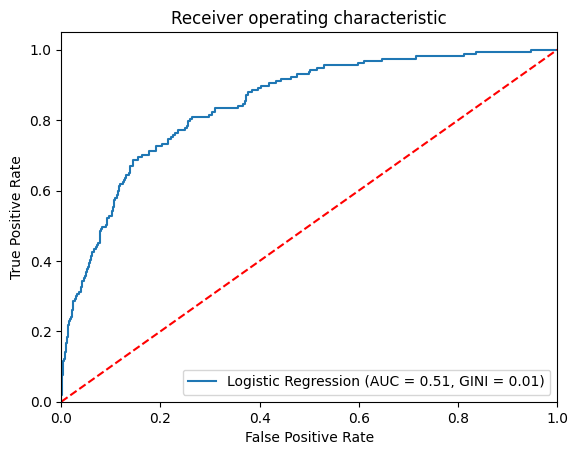

In [34]:
# selected variables for final model
selected_variables = ["var5_LF","var6_LF","var7_PE","var9_LF","var14_LF","var16_AQ","var18_CL","Num_of_Miss"]

# split data set into dependent and independent variables
X_train = train[selected_variables]
y_train = train["deflag"]
X_test = test[selected_variables]
y_test = test["deflag"]

# estimate model using training dataset
model = LogisticRegression()
model.fit(X_train, y_train)

# based on model, predict deflag on test dataset and calculate accuracy
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

# calculate R-squared of regression model
r_squared_train = model.score(X_train, y_train)
r_squared_test = model.score(X_test, y_test)

adj_r_squared_train = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adj_r_squared_test = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print('R-square: \n', 'train: ', r_squared_train, '\n test: ', r_squared_test)
print('R-square adjusted: \n', 'train: ', adj_r_squared_train, '\n test: ', adj_r_squared_test)

# confusion matrix based on test dataset between predicted and actual deflag
print(confusion_matrix(y_test, y_pred))

# ROC curve and GINI of final model
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
logit_roc_auc = roc_auc_score(y_test, pd.DataFrame(model.predict(X_test)))

logit_gini_train = 2 * roc_auc_score(y_train, model.predict(X_train)) - 1
logit_gini_test = 2 * roc_auc_score(y_test, model.predict(X_test)) - 1
print('GINI: \n', 'train: ', logit_gini_train, '\n test: ', logit_gini_test)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f, GINI = %0.2f)' % (logit_roc_auc, logit_gini_test))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(my_path + "/Plot/" + 'FinalModel' + '_ROC.png')
plt.show()
plt.close('all')
